MLP for BCH(15, 7, 2)

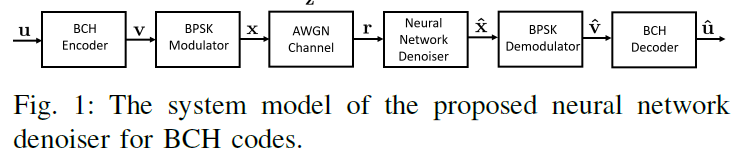

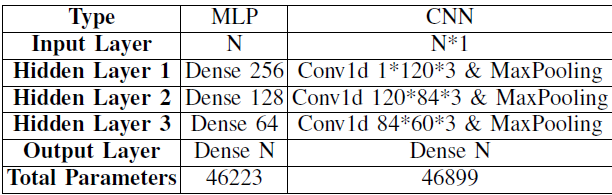

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import random
import csv
import pandas as pd
import itertools

In [2]:
#BCH(15, 7, 2)
n = 15
k = 7
t = 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Eb_N0_test = [0, 1, 2, 3, 4, 5, 6, 7]

# hyperparameters
input_size = n
hidden_size_1 = 256
hidden_size_2 = 128
hidden_size_3 = 64
output_size = n
num_epochs = 16384
batch_size = 8
learning_rate = 0.0005

Read and prepare datasets

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels = torch.tensor([float(x) for x in self.data.iloc[idx, 1].split(',')]).float()
        features = torch.tensor([float(x) for x in self.data.iloc[idx, 3].split(',')]).float()

        if self.transform:
            features = self.transform(features)
        return labels, features

In [5]:
test_dataset, test_loader = {}, {}

train_dataset = CustomDataset(csv_file="train_dataset.csv", transform=None)
for elem in Eb_N0_test:
    test_dataset[elem] = CustomDataset(csv_file=f"test_dataset/test_dataset_{elem}.csv", transform=None)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  
for elem in Eb_N0_test:
    test_loader[elem] = DataLoader(dataset=test_dataset[elem], batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset[0]), len(test_loader[0]))
print(train_dataset[34567])
print(test_dataset[3][1483])

100096 125056 15632
(tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.]), tensor([ 0.8317, -1.2640,  0.5736, -1.3900, -0.1949,  0.4351,  1.0525, -1.2029,
         0.1784,  1.4942,  1.0352, -0.7556, -0.6715, -0.5234, -1.5511]))
(tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.]), tensor([ 0.6452,  0.1995,  0.9710,  1.0041,  0.8379,  1.2816, -1.1709, -0.7907,
        -1.0328,  0.4010, -1.1391,  0.7684,  0.8681,  0.3751, -0.7922]))


Multi Layer Perceptron network

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.ReLU(),
            nn.Linear(hidden_size_3, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = MLP(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size).to(device)
# print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Count BER function

In [8]:
def count_ber(input_codeword, output_codeword):
    ber = torch.mean((input_codeword != output_codeword).float()).item()
    return ber

Training

In [9]:
num_epochs = 4
print(len(train_dataset))
print(len(train_loader), "\n")

for epoch in range(num_epochs):
    running_ber = 0.0
    
    for batch_labels, batch_features in train_loader:
        # Upewnij się, że etykiety są w formacie float
        batch_labels = batch_labels.float()  # Zmieniamy etykiety na float

        # Forward pass
        outputs = model(batch_features)  # Uzyskaj wyjścia modelu
        loss = criterion(outputs, batch_labels)  # Oblicz stratę

        # Backward pass i optymalizacja
        optimizer.zero_grad()  # Wyzeruj gradienty
        loss.backward()  # Oblicz gradienty
        optimizer.step()  # Zaktualizuj wagi

        predicted = (outputs > 0.5).float()
        running_ber += count_ber(predicted, batch_labels)
      
    average_ber = running_ber / len(train_loader)

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, BER: {average_ber:.4f}')

100096
12512 

Epoch [1/4], Loss: 0.1125, BER: 0.0614
Epoch [2/4], Loss: 0.1288, BER: 0.0310
Epoch [3/4], Loss: 0.1165, BER: 0.0226
Epoch [4/4], Loss: 0.1331, BER: 0.0191


Testing

MLP denoiser

In [14]:
predictions = {}

def test(Eb_N0):
    model.eval()
    
    total_correct = 0
    total_samples = 0
    running_ber = 0.0
    num_of_test_batches = len(test_loader[Eb_N0[0]])
    
    with torch.no_grad():  # Nie obliczaj gradientów
        # Uzyskaj pierwsze 5 wierszy z test_loader
        for elem in Eb_N0:
            predictions[elem] = []  # Lista na predykcje dla każdego elem
            
            for i, (batch_labels, batch_features) in enumerate(test_loader[elem]):
                # Przenieś dane do odpowiedniego urządzenia
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)
        
                # Forward pass
                outputs = model(batch_features)
                
                # Użyj Sigmoidu do przekształcenia wyjść w przedziale [0, 1]
                predicted = (outputs > 0.5).float()
                
                # Zliczaj poprawne przewidywania i liczbę etykiet
                total_correct += (predicted == batch_labels).sum().item()
                total_samples += batch_labels.numel()
                
                # Sumuj BER dla każdego batcha
                running_ber += count_ber(predicted, batch_labels)
                
                # Zapisz predykcje dla tego batcha w formacie listy stringów
                batch_predictions = [", ".join(map(str, pred.tolist())) for pred in predicted]
                predictions[elem].extend(batch_predictions)
        
    
    accuracy = 100.0 * total_correct / total_samples
    average_ber = running_ber / (num_of_test_batches * len(Eb_N0))

    print(f'Eb_N0 = {Eb_N0}')
    print(f'Accuracy of the model of {num_of_test_batches * batch_size * len(Eb_N0)} samples: {accuracy:.2f}%')
    print(f'BER: {average_ber:.4f}')

test([0])
print("\n")
test(Eb_N0_test)

Eb_N0 = [0]
Accuracy of the model of 125056 samples: 98.09%
BER: 0.0191


Eb_N0 = [0, 1, 2, 3, 4, 5, 6, 7]
Accuracy of the model of 1000448 samples: 99.62%
BER: 0.0038


In [18]:
def save_test_results(Eb_N0):
    input_file = f"test_dataset/test_dataset_{Eb_N0}.csv"
    output_file = f"output/output_{Eb_N0}.csv"
    
    # Wczytaj dane z testowego pliku CSV
    data = pd.read_csv(input_file, usecols=["message", f"awgn_sign_codeword_binary_{Eb_N0}"])
    
    # Dodaj kolumnę z predykcjami do DataFrame
    data[f"mlp_denoised_{Eb_N0}"] = predictions[Eb_N0]
    
    # Zapisz DataFrame do pliku CSV
    data.to_csv(output_file, index=False)
    print(f"File created: {output_file}")

In [19]:
for elem in Eb_N0_test:
    save_test_results(elem)

File created: output/output_0.csv
File created: output/output_1.csv
File created: output/output_2.csv
File created: output/output_3.csv
File created: output/output_4.csv
File created: output/output_5.csv
File created: output/output_6.csv
File created: output/output_7.csv


BCH Decoder only

BCH Decoder with MLP denoiser

In [28]:
import bchlib; help(bchlib)

Help on module BCH:

NAME
    BCH - BCH Library

CLASSES
    builtins.object
        bchlib.BCH
    
    class BCH(builtins.object)
     |  BCH Encoder/Decoder
     |  
     |  __init__(t, poly=None, m=None, swap_bits=False) → bch
     |      Constructor creates a BCH object with given 't' bit strength.  At
     |      least one of 'poly' and/or 'm' must be provided.  If 'poly' is
     |      provided but 'm' (Galois field order) is not, 'm' will be
     |      calculated automatically.  If 'm' between 5 and 15 inclusive is'
     |      provided, 'polywill be selected automatically.  The 'swap_bits'
     |      parameter will reverse the bit order within data and syndrome
     |      bytes.
     |  
     |  Methods defined here:
     |  
     |  __getattribute__(self, name, /)
     |      Return getattr(self, name).
     |  
     |  __init__(self, /, *args, **kwargs)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  compute_even_syn(...)
     |

In [31]:
bch = bchlib.BCH(15, m=7)

In [1]:
import matlab.engine

ModuleNotFoundError: No module named 'matlab'